In [1]:
#importing the library's 

import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [192]:
#Setting graph style

plt.style.use(['ggplot'])
plt.rcParams['axes.facecolor']='w'
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams["axes.grid"] = True



In [4]:
link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'

In [5]:
df = pd.read_excel(link)

In [6]:
#df = pd.read_excel('./OnlineRetail.xlsx')

In [7]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [8]:
#Data clean - Columns 

df.columns = df.columns.str.strip().str.lower().str.replace("[!_()]", " ")


In [9]:
df.columns

Index(['invoiceno', 'stockcode', 'description', 'quantity', 'invoicedate',
       'unitprice', 'customerid', 'country'],
      dtype='object')

In [134]:
#Finding unique values 

for i in df.columns:
    print(i)


print('Data size (row & col counts) : {dim}'.format(dim = df.shape))
print('Unique invoices n            : {cnt}'.format(cnt = df.invoiceno.nunique()))
print('unique cust ids              : {cnt}'.format(cnt = df.customerid.nunique()))



invoiceno
stockcode
description
quantity
invoicedate
unitprice
customerid
country
Data size (row & col counts) : (541909, 8)
Unique invoices n            : 25900
unique cust ids              : 4372


In [11]:
#Deleting any transactions with empty invoice and no description

data = df.dropna(axis=0, subset=['invoiceno'    ])


print('Data size (row & col counts) : {dim}'.format(dim = df.shape))

Data size (row & col counts) : (541909, 8)


In [12]:
data.isnull().sum()

invoiceno           0
stockcode           0
description      1454
quantity            0
invoicedate         0
unitprice           0
customerid     135080
country             0
dtype: int64

In [13]:
data = df.dropna(axis=0, subset=['description'])

print('Data size (row & col counts) : {dim}'.format(dim = df.shape))

Data size (row & col counts) : (541909, 8)


In [14]:
data.isnull().sum()

invoiceno           0
stockcode           0
description         0
quantity            0
invoicedate         0
unitprice           0
customerid     133626
country             0
dtype: int64

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 540455 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoiceno    540455 non-null  object        
 1   stockcode    540455 non-null  object        
 2   description  540455 non-null  object        
 3   quantity     540455 non-null  int64         
 4   invoicedate  540455 non-null  datetime64[ns]
 5   unitprice    540455 non-null  float64       
 6   customerid   406829 non-null  float64       
 7   country      540455 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 37.1+ MB


In [16]:
data = data[data['quantity']>=0]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530693 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoiceno    530693 non-null  object        
 1   stockcode    530693 non-null  object        
 2   description  530693 non-null  object        
 3   quantity     530693 non-null  int64         
 4   invoicedate  530693 non-null  datetime64[ns]
 5   unitprice    530693 non-null  float64       
 6   customerid   397924 non-null  float64       
 7   country      530693 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.4+ MB


In [141]:
#Converting invoice and description to string

data['invoiceno'] =  data['invoiceno'].astype('str')
data['description'] = data['description'].astype('str')
data['description'] = data['description'].str.strip()
data['description'] = data['description'].str.replace('*', '')
data['description'] = data['description'].str.replace('?', 'UxxxNT')



In [18]:
#Dealing with Credit notes, Adjustments, Dotcom postage, etc

data = data[~data['invoiceno'  ].str.contains('C')]
data = data[~data['invoiceno'  ].str.contains('A')]
data = data[~data['description'].str.contains('POSTAGE')]
data = data[~data['description'].str.contains('20713')]
data = data[~data['description'].str.contains('SAMPLE')]
data = data[~data['description'].str.contains('UxxxNT')]
data = data[~data['description'].str.contains('Manual')]
data = data[~data['description'].str.contains('AMAZON FEE')]
data = data[~data['description'].str.contains('Bank charges')]
data = data[~data['description'].str.contains('ebay')]
data = data[~data['description'].str.contains('Gift Voucher')]
data = data[~data['description'].str.contains('damages')]
data = data[~data['description'].str.contains('to push order')]


print('Data size (row & col counts) : {dim}'.format(dim = data.shape))
print('Unique invoices n            : {cnt}'.format(cnt = data.invoiceno.nunique()))
print('unique cust ids              : {cnt}'.format(cnt = data.customerid.nunique()))
                       

Data size (row & col counts) : (528482, 8)
Unique invoices n            : 19959
unique cust ids              : 4336


In [142]:
data.describe()

,quantity,unitprice,customerid
count,528482.000000,528482.000000,396519.000000
mean,10.605674,3.274412,15301.351718
std,156.714938,4.443830,1709.777503
min,1.000000,0.000000,12346.000000
25%,1.000000,1.250000,13975.000000
50%,3.000000,2.080000,15159.000000
75%,11.000000,4.130000,16801.000000
max,80995.000000,649.500000,18287.000000


<AxesSubplot:ylabel='Frequency'>

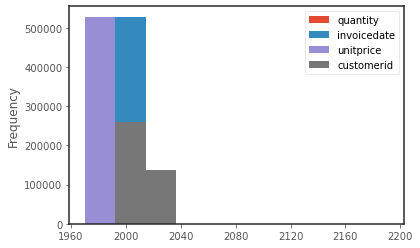

In [143]:
data.plot(kind='hist')

In [133]:
country_df = data['country'].unique()
N = len(country_df)
i = 0
for nation in country_df:
    print(i, nation)
    i=i+1

0 United Kingdom
1 France
2 Australia
3 Netherlands
4 Germany
5 Norway
6 EIRE
7 Switzerland
8 Spain
9 Poland
10 Portugal
11 Italy
12 Belgium
13 Lithuania
14 Japan
15 Iceland
16 Channel Islands
17 Denmark
18 Cyprus
19 Sweden
20 Finland
21 Austria
22 Bahrain
23 Israel
24 Greece
25 Hong Kong
26 Singapore
27 Lebanon
28 United Arab Emirates
29 Saudi Arabia
30 Czech Republic
31 Canada
32 Unspecified
33 Brazil
34 USA
35 European Community
36 Malta
37 RSA


In [137]:
top_3 = data.groupby('country').agg({'quantity': 'sum'}).sort_values('quantity', ascending=False)[:3]

In [138]:
top_3

,quantity
country,
United Kingdom,4680878
Netherlands,200834
EIRE,147442


<AxesSubplot:xlabel='country'>

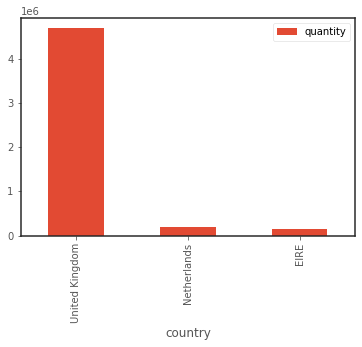

In [139]:
top_3.plot(kind='bar')



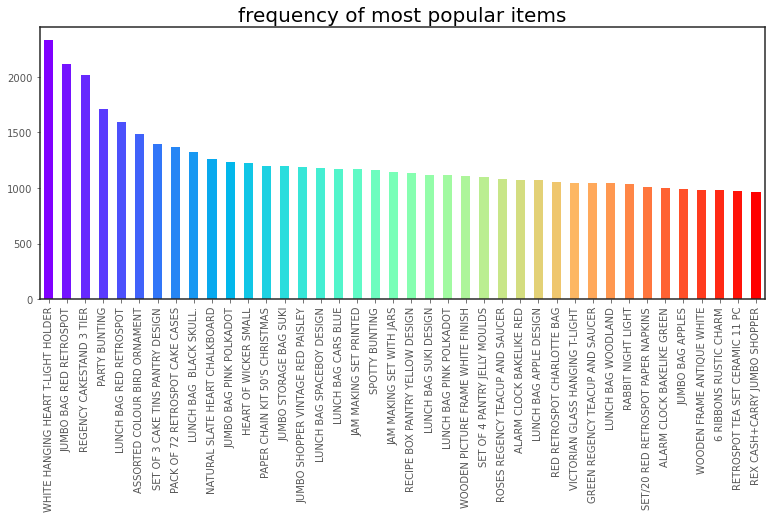

In [48]:
color = plt.cm.rainbow(np.linspace(0, 1, 40))
data['description'].value_counts().head(40).plot.bar(color = color, figsize=(13,5))
plt.title('frequency of most popular items', fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()


In [23]:
#Saving the cleaned data to a csv file format to check if any more filters are needed before training the model

data.to_csv('/Users/pamel/Downloads/retailclean.csv', index=False)

In [24]:
# Defining the hot encoding function to make the data suitable
# for the concerned libraries
#def hot_encode(x):
    #if(x<= 0):
        #return 0
    #if(x>= 1):
        #return 1

In [25]:
df_UK = data.copy()

In [26]:
df_NE = data.copy()

In [27]:
df_EI = data.copy()

In [28]:
####################################################################### uk ##############################

In [29]:
#Splitting Basket for UK

Items_UK = (df_UK[df_UK['country'] =="United Kingdom"])
          

Items_UK = pd.DataFrame(Items_UK)

Items_UK

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom


In [30]:
# Quantity of unique items

Items_UK['description'].nunique()

4029

In [178]:
# Unique items quantity/description

Items_UK['description'].value_counts().sort_values(ascending=False).head(20)

WHITE HANGING HEART T-LIGHT HOLDER    2231
JUMBO BAG RED RETROSPOT               1960
REGENCY CAKESTAND 3 TIER              1711
PARTY BUNTING                         1615
LUNCH BAG RED RETROSPOT               1421
ASSORTED COLOUR BIRD ORNAMENT         1405
LUNCH BAG  BLACK SKULL.               1271
SET OF 3 CAKE TINS PANTRY DESIGN      1255
NATURAL SLATE HEART CHALKBOARD        1233
HEART OF WICKER SMALL                 1188
JUMBO BAG PINK POLKADOT               1179
PACK OF 72 RETROSPOT CAKE CASES       1178
PAPER CHAIN KIT 50'S CHRISTMAS        1163
JUMBO SHOPPER VINTAGE RED PAISLEY     1148
JUMBO STORAGE BAG SUKI                1143
LUNCH BAG CARS BLUE                   1089
WOODEN PICTURE FRAME WHITE FINISH     1087
SPOTTY BUNTING                        1059
LUNCH BAG SPACEBOY DESIGN             1059
LUNCH BAG SUKI DESIGN                 1055
Name: description, dtype: int64

In [32]:
Items_UK=Items_UK.drop(Items_UK.loc[Items_UK['description']=='CARRIAGE'].index)

Text(0.5, 1.0, 'Best sellers UK')

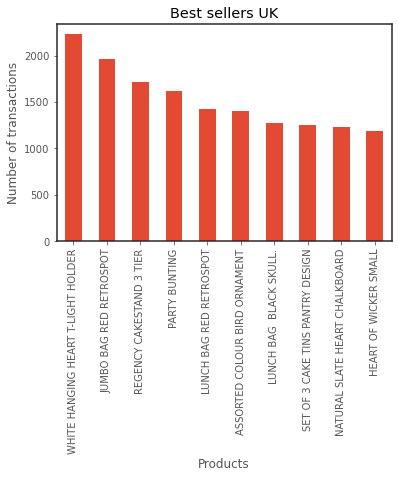

In [144]:
# Plotting best seller products
fig, ax=plt.subplots(figsize=(6,4))
Items_UK['description'].value_counts().sort_values(ascending=False).head(10).plot(kind='bar')
plt.ylabel('Number of transactions')
plt.xlabel('Products')
ax.get_yaxis().get_major_formatter().set_scientific(False)
plt.title('Best sellers UK')

In [34]:
#adding a Hour columns to show business best sale times

Items_UK['invoicedate'] = pd.to_datetime(Items_UK['invoicedate'])
Items_UK['Hour'] = Items_UK['invoicedate'].dt.hour
Items_UK['Minute'] = Items_UK['invoicedate'].dt.minute
Items_UK['Count'] = 1

Items_UK.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,Hour,Minute,Count
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,8,26,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,26,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,8,26,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,26,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,26,1


In [35]:
hours = [pair for pair, df in Items_UK.groupby(['Hour'])]

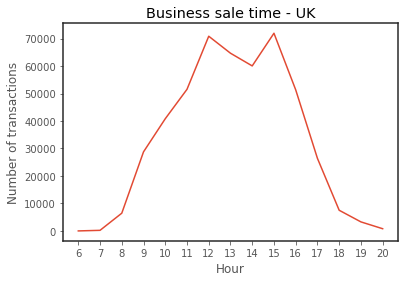

In [36]:
#Business best sale time

plt.figure(figsize=(6,4))
plt.plot(hours, Items_UK.groupby(['Hour']).count()['Count'])
plt.xticks(hours)
plt.xlabel("Hour")
plt.ylabel("Number of transactions")
plt.title('Business sale time - UK')
plt.grid()
plt.show()

In [37]:
#Extractin Months and Years for further analysis 

Items_UK['month'] = pd.DatetimeIndex(Items_UK['invoicedate']).month
Items_UK['Month_name']=Items_UK['invoicedate'].dt.month_name()
Items_UK['Year']=Items_UK['invoicedate'].dt.year
Items_UK['Year_Month']=Items_UK['Year'].apply(str)+' '+Items_UK['Month_name'].apply(str)

Items_UK

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,Hour,Minute,Count,month,Month_name,Year,Year_Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,8,26,1,12,December,2010,2010 December
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,26,1,12,December,2010,2010 December
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,8,26,1,12,December,2010,2010 December
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,26,1,12,December,2010,2010 December
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,26,1,12,December,2010,2010 December
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom,12,31,1,12,December,2011,2011 December
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom,12,49,1,12,December,2011,2011 December
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom,12,49,1,12,December,2011,2011 December
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom,12,49,1,12,December,2011,2011 December


Text(0.5, 1.0, 'Monthly/Year sales performance UK')

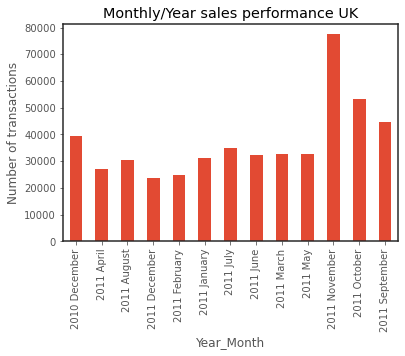

In [145]:
#Monthly/Year sales review

Items_UK.groupby('Year_Month')['description'].count().plot(kind='bar')
plt.ylabel('Number of transactions')
plt.title('Monthly/Year sales performance UK')

In [39]:
#Monthly bestseller product - 12 DAISY PEGS IN WOOD BOX in April

Items_UK2=Items_UK.pivot_table(index='Month_name',columns='description', aggfunc={'description':'count'}).fillna(0)
Items_UK2['Max']=Items_UK2.idxmax(axis=1)
Items_UK2.head(5)

description                             \
description 10 COLOUR SPACEBOY PEN 12 COLOURED PARTY BALLOONS   
Month_name                                                      
April                         13.0                       12.0   
August                        13.0                       14.0   
December                      48.0                       13.0   
February                      12.0                        5.0   
January                       13.0                        5.0   

                                                                 \
description 12 DAISY PEGS IN WOOD BOX 12 EGG HOUSE PAINTED WOOD   
Month_name                                                        
April                            12.0                       8.0   
August                            2.0                       4.0   
December                         10.0                      10.0   
February                          4.0                       8.0   
January                          16.0                       8.0   

                                                                           \
description 12 HANGING EGGS HAND PAINTED 12 IVORY ROSE PEG PLACE SETTINGS   
Month_name                                                                  
April                                0.0                             12.0   
August                               0.0                             12.0   
December                             3.0                              7.0   
February                             0.0                             16.0   
January                              0.0                             15.0   

                                                                           \
description 12 MESSAGE CARDS WITH ENVELOPES 12 PENCIL SMALL TUBE WOODLAND   
Month_name                                                                  
April                                  12.0                          20.0   
August                                 14.0                           0.0   
December                               48.0                          74.0   
February                               10.0                           5.0   
January                                19.0                          15.0   

                                                                             \
description 12 PENCILS SMALL TUBE RED RETROSPOT 12 PENCILS SMALL TUBE SKULL   
Month_name                                                                    
April                                      26.0                        21.0   
August                                      0.0                        15.0   
December                                   74.0                        49.0   
February                                   18.0                        15.0   
January                                    24.0                        23.0   

             ...                                                           \
description  ... rcvd be air temp fix for dotcom sit returned taig adjust   
Month_name   ...                                                            
April        ...                                 0.0      2.0         0.0   
August       ...                                 0.0      0.0         0.0   
December     ...                                 0.0      0.0         0.0   
February     ...                                 0.0      0.0         0.0   
January      ...                                 0.0      0.0         0.0   

                                                                   \
description test website fixed wrongly coded 23343 wrongly marked   
Month_name                                                          
April        0.0           0.0                 0.0            0.0   
August       0.0           0.0                 0.0            0.0   
December     0.0           0.0                 0.0            0.0   
February     0.0           0.0                 0.0            0.0  

In [40]:
#Apriori Algorithm and Association analysanalysis 
#Sppliting the data 

basket_UK = (df_UK[df_UK['country'] =="United Kingdom"]
          .groupby(['invoiceno', 'description'])['quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('invoiceno'))

basket_UK

description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,...,on cargo order,rcvd be air temp fix for dotcom sit,returned,taig adjust,test,website fixed,wrongly coded 23343,wrongly marked,wrongly marked 23343,wrongly sold (22719) barcode
invoiceno,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
#lists of items that are bought together.

lst=[]

for items in Items_UK['invoiceno'].unique():
    lst2=list(set(Items_UK[Items_UK['invoiceno']==items]['description']))
    if len(lst2)>0:
        lst.append(lst2)
        
print(lst[0:2])
print(len(lst))

[['RED WOOLLY HOTTIE WHITE HEART.', 'SET 7 BABUSHKA NESTING BOXES', 'KNITTED UNION FLAG HOT WATER BOTTLE', 'WHITE METAL LANTERN', 'GLASS STAR FROSTED T-LIGHT HOLDER', 'CREAM CUPID HEARTS COAT HANGER', 'WHITE HANGING HEART T-LIGHT HOLDER'], ['HAND WARMER RED POLKA DOT', 'HAND WARMER UNION JACK']]
18083


In [56]:
# Defining the hot encoding function to make the data suitable
# for the concerned libraries
def hot_encode(x):
    if(x<= 0):
        return 0
    if(x>= 1):
        return 1

In [57]:
# Encoding the dataset
basket_encoded = basket_UK.applymap(hot_encode)
basket_UK = basket_encoded


# Building the model
UKfrq_items = apriori(basket_UK, min_support = 0.02, use_colnames = True)
 
# Collecting the inferred rules in a dataframe
UKrules = association_rules(UKfrq_items, metric ="lift", min_threshold = 1)
UKrules = UKrules.sort_values(['confidence', 'lift'], ascending =[False, False])

#saving results in dataframe
UKrule = pd.DataFrame(UKrules)

UKrule

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
182,"(ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.030194,0.051651,0.027263,0.902930,17.481467,0.025704,9.769787
184,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER),0.031908,0.052923,0.027263,0.854419,16.144688,0.025574,6.505520
24,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.038876,0.051651,0.031908,0.820768,15.890739,0.029900,5.291187
190,"(JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO BAG ...",(JUMBO BAG RED RETROSPOT),0.025106,0.107172,0.020240,0.806167,7.522149,0.017549,4.606178
196,"(JUMBO STORAGE BAG SUKI, JUMBO BAG PINK POLKADOT)",(JUMBO BAG RED RETROSPOT),0.027927,0.107172,0.022397,0.801980,7.483079,0.019404,4.508779
...,...,...,...,...,...,...,...,...,...
191,(JUMBO BAG RED RETROSPOT),"(JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO BAG ...",0.107172,0.025106,0.020240,0.188854,7.522149,0.017549,1.201873
85,(JUMBO BAG RED RETROSPOT),(LUNCH BAG BLACK SKULL.),0.107172,0.067245,0.020185,0.188338,2.800761,0.012978,1.149192
177,(WHITE HANGING HEART T-LIGHT HOLDER),(WOODEN PICTURE FRAME WHITE FINISH),0.119781,0.059503,0.022341,0.186519,3.134593,0.015214,1.156138
159,(WHITE HANGING HEART T-LIGHT HOLDER),(PARTY BUNTING),0.119781,0.088149,0.020904,0.174515,1.979774,0.010345,1.104625


In [58]:
UKproductA = list(UKrule.iloc[0,0])[0]
print('The top seller product is', UKproductA)

UKNA = int(basket_UK[UKproductA].sum())
print('which was sold', UKNA , 'times')

UKproductB = list(UKrule.iloc[0,1])[0]
print('sold together with', UKproductB)

UKNB = int(basket_UK[UKproductB].sum())
print(' which was sold', UKNB)

UKlift_A_C = str(round(UKrule.iloc[0,6],2))

The top seller product is ROSES REGENCY TEACUP AND SAUCER
which was sold 957 times
sold together with GREEN REGENCY TEACUP AND SAUCER
 which was sold 934


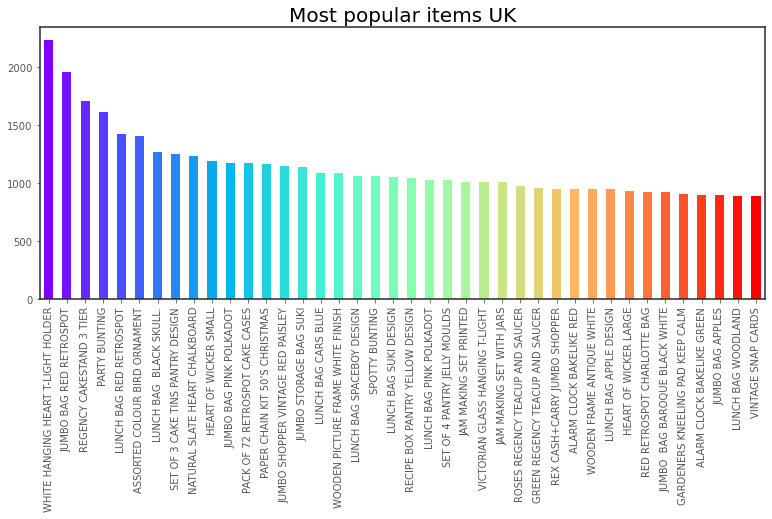

In [146]:
color = plt.cm.rainbow(np.linspace(0, 1, 40))
Items_UK['description'].value_counts().head(40).plot.bar(color = color, figsize=(13,5))
plt.title('Most popular items UK', fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

In [202]:
UKrule_sort = UKrule.sort_values(['confidence', 'lift'], ascending =False)[:50]

UKrule_sort

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
182,"(ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.030194,0.051651,0.027263,0.902930,17.481467,0.025704,9.769787
184,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER),0.031908,0.052923,0.027263,0.854419,16.144688,0.025574,6.505520
24,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.038876,0.051651,0.031908,0.820768,15.890739,0.029900,5.291187
190,"(JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO BAG ...",(JUMBO BAG RED RETROSPOT),0.025106,0.107172,0.020240,0.806167,7.522149,0.017549,4.606178
196,"(JUMBO STORAGE BAG SUKI, JUMBO BAG PINK POLKADOT)",(JUMBO BAG RED RETROSPOT),0.027927,0.107172,0.022397,0.801980,7.483079,0.019404,4.508779
161,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.038876,0.052923,0.030194,0.776671,14.675600,0.028137,4.240735
180,(WOODEN STAR CHRISTMAS SCANDINAVIAN),(WOODEN HEART CHRISTMAS SCANDINAVIAN),0.026489,0.028148,0.020351,0.768267,27.293863,0.019605,4.193848
29,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.051651,0.052923,0.038766,0.750535,14.181745,0.036032,3.796439
202,"(JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO STOR...",(JUMBO BAG RED RETROSPOT),0.028369,0.107172,0.021235,0.748538,6.984424,0.018195,3.550547
28,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.052923,0.051651,0.038766,0.732497,14.181745,0.036032,3.545196


In [203]:
UKrule_sort.antecedents = UKrule_sort.antecedents.apply(lambda x: next(iter(x)))
UKrule_sort.consequents = UKrule_sort.consequents.apply(lambda x: next(iter(x)))

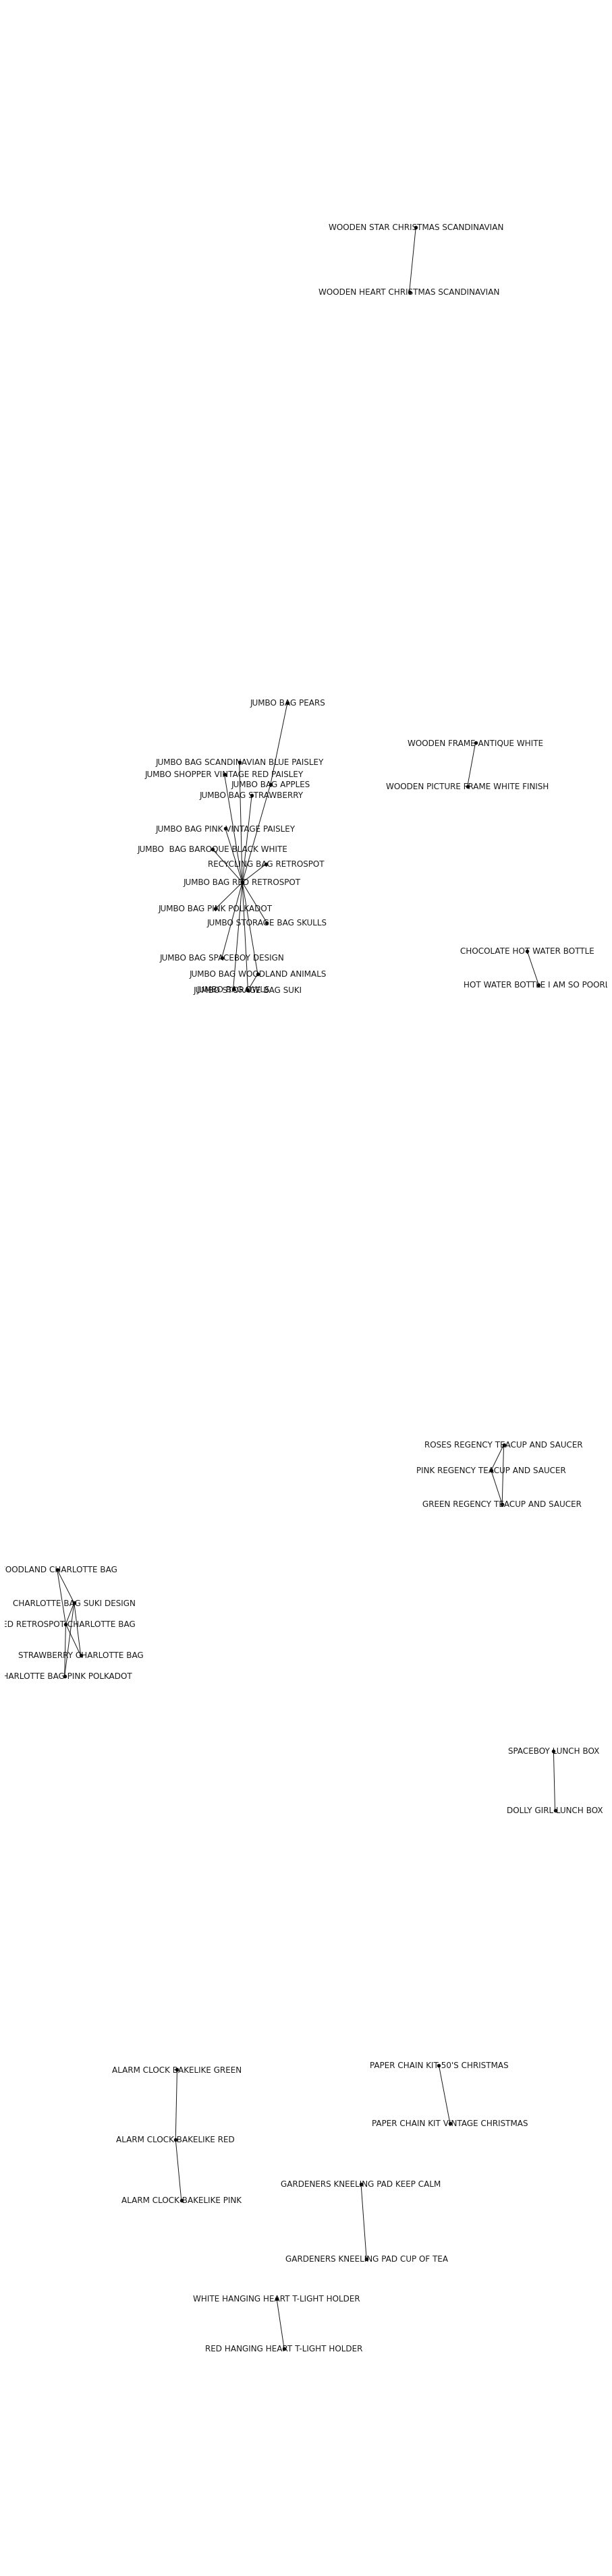

In [219]:
import networkx as nx

fig, ax=plt.subplots(figsize=(16,70))
GA=nx.from_pandas_edgelist(UKrule_sort,source='antecedents',target='consequents')
nx.draw(GA,node_size=20, node_color='black',  with_labels=True, alpha=0.9, width=1, linewidths=1)
plt.savefig('labels.png')
plt.show()



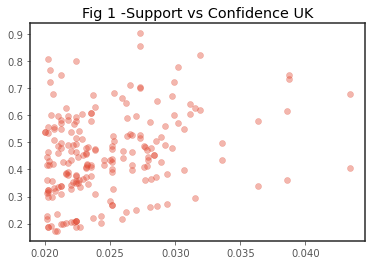

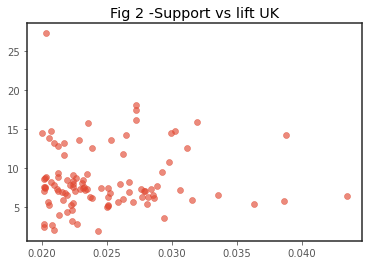

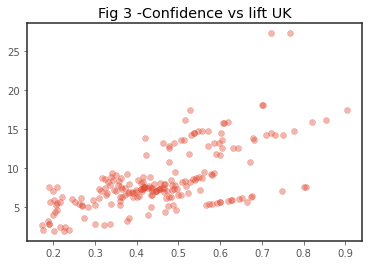

In [147]:
# Plotting results - Support vs Confidence vs lift

plt.scatter(UKrule['support'], UKrule['confidence'], alpha=0.4)
plt.title('Fig 1 -Support vs Confidence UK')
plt.show()

plt.scatter(UKrule['support'], UKrule['lift'], alpha=0.4)
plt.title('Fig 2 -Support vs lift UK')
plt.show()



plt.scatter(UKrule['confidence'], UKrule['lift'], alpha=0.4)
plt.title('Fig 3 -Confidence vs lift UK')
plt.show()

In [ ]:
#######################################################################Netherlands ##############################

In [189]:
#Setting graph style

plt.style.use(['seaborn-colorblind'])


In [65]:
#Splitting Basket Netherlands

Items_NE = (df_NE[df_NE['country'] =="Netherlands"])
          

Items_NE = pd.DataFrame(Items_NE)

Items_NE

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
385,536403,22867,HAND WARMER BIRD DESIGN,96,2010-12-01 11:27:00,1.85,12791.0,Netherlands
37952,539491,21981,PACK OF 12 WOODLAND TISSUES,12,2010-12-20 10:09:00,0.29,14646.0,Netherlands
37953,539491,21986,PACK OF 12 PINK POLKADOT TISSUES,12,2010-12-20 10:09:00,0.29,14646.0,Netherlands
37954,539491,22720,SET OF 3 CAKE TINS PANTRY DESIGN,2,2010-12-20 10:09:00,4.95,14646.0,Netherlands
37955,539491,21931,JUMBO STORAGE BAG SUKI,1,2010-12-20 10:09:00,1.95,14646.0,Netherlands
...,...,...,...,...,...,...,...,...
534958,581176,22908,PACK OF 20 NAPKINS RED APPLES,96,2011-12-07 15:19:00,0.72,14646.0,Netherlands
534959,581176,22907,PACK OF 20 NAPKINS PANTRY DESIGN,96,2011-12-07 15:19:00,0.72,14646.0,Netherlands
534960,581176,22029,SPACEBOY BIRTHDAY CARD,72,2011-12-07 15:19:00,0.36,14646.0,Netherlands
534961,581176,22712,CARD DOLLY GIRL,72,2011-12-07 15:19:00,0.36,14646.0,Netherlands


In [66]:
# Quantity of unique items

Items_NE['description'].nunique()

802

In [179]:
# Unique items quantity/description

Items_NE['description'].value_counts().sort_values(ascending=False).head(20)

SPACEBOY LUNCH BOX                    28
ROUND SNACK BOXES SET OF4 WOODLAND    25
DOLLY GIRL LUNCH BOX                  22
SPACEBOY BIRTHDAY CARD                17
ROUND SNACK BOXES SET OF 4 FRUITS     17
WOODLAND CHARLOTTE BAG                16
STRAWBERRY LUNCH BOX WITH CUTLERY     14
JUMBO BAG RED RETROSPOT               14
RED TOADSTOOL LED NIGHT LIGHT         14
PACK OF 72 RETROSPOT CAKE CASES       13
CHILDRENS APRON SPACEBOY DESIGN       13
FAWN BLUE HOT WATER BOTTLE            13
GUMBALL COAT RACK                     13
PLASTERS IN TIN SPACEBOY              12
RED RETROSPOT CHARLOTTE BAG           12
CARD DOLLY GIRL                       12
LUNCH BAG SPACEBOY DESIGN             12
SET OF 3 REGENCY CAKE TINS            12
CIRCUS PARADE LUNCH BOX               11
CHARLOTTE BAG PINK POLKADOT           11
Name: description, dtype: int64

In [68]:
# Removed CARRIAGE (not a product)

Items_NE=Items_NE.drop(Items_NE.loc[Items_NE['description']=='CARRIAGE'].index)

Text(0.5, 1.0, 'Best sellers Netherlands ')

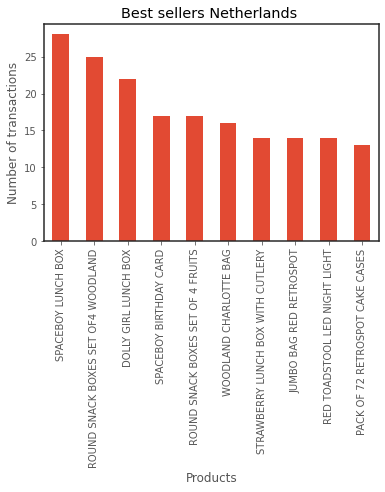

In [184]:
# Plotting best seller products

fig, ax=plt.subplots(figsize=(6,4))
Items_NE['description'].value_counts().sort_values(ascending=False).head(10).plot(kind='bar')
plt.ylabel('Number of transactions')
plt.xlabel('Products')
ax.get_yaxis().get_major_formatter().set_scientific(False)
plt.title('Best sellers Netherlands ')

In [70]:
#adding a Hour columns to show business best sale times

Items_NE['invoicedate'] = pd.to_datetime(Items_NE['invoicedate'])
Items_NE['Hour'] = Items_NE['invoicedate'].dt.hour
Items_NE['Minute'] = Items_NE['invoicedate'].dt.minute
Items_NE['Count'] = 1

Items_NE.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,Hour,Minute,Count
385,536403,22867,HAND WARMER BIRD DESIGN,96,2010-12-01 11:27:00,1.85,12791.0,Netherlands,11,27,1
37952,539491,21981,PACK OF 12 WOODLAND TISSUES,12,2010-12-20 10:09:00,0.29,14646.0,Netherlands,10,9,1
37953,539491,21986,PACK OF 12 PINK POLKADOT TISSUES,12,2010-12-20 10:09:00,0.29,14646.0,Netherlands,10,9,1
37954,539491,22720,SET OF 3 CAKE TINS PANTRY DESIGN,2,2010-12-20 10:09:00,4.95,14646.0,Netherlands,10,9,1
37955,539491,21931,JUMBO STORAGE BAG SUKI,1,2010-12-20 10:09:00,1.95,14646.0,Netherlands,10,9,1


In [152]:
hours = [pair for pair, df in Items_NE.groupby(['Hour'])]

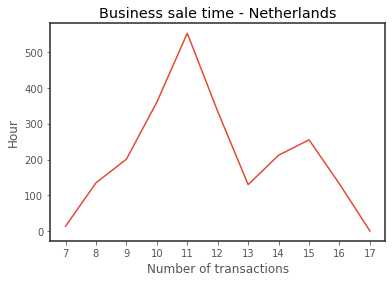

In [157]:
#Business best sale time

plt.figure(figsize=(6,4))
plt.plot(hours, Items_NE.groupby(['Hour']).count()['Count'])
plt.xticks(hours)
plt.xlabel("Number of transactions")
plt.ylabel("Hour")
plt.title('Business sale time - Netherlands')
plt.grid()
plt.show()


In [73]:
#Extractin Months and Years for further analysis 

Items_NE['month'] = pd.DatetimeIndex(Items_NE['invoicedate']).month
Items_NE['Month_name']=Items_NE['invoicedate'].dt.month_name()
Items_NE['Year']=Items_NE['invoicedate'].dt.year
Items_NE['Year_Month']=Items_NE['Year'].apply(str)+' '+Items_NE['Month_name'].apply(str)

Items_NE

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,Hour,Minute,Count,month,Month_name,Year,Year_Month
385,536403,22867,HAND WARMER BIRD DESIGN,96,2010-12-01 11:27:00,1.85,12791.0,Netherlands,11,27,1,12,December,2010,2010 December
37952,539491,21981,PACK OF 12 WOODLAND TISSUES,12,2010-12-20 10:09:00,0.29,14646.0,Netherlands,10,9,1,12,December,2010,2010 December
37953,539491,21986,PACK OF 12 PINK POLKADOT TISSUES,12,2010-12-20 10:09:00,0.29,14646.0,Netherlands,10,9,1,12,December,2010,2010 December
37954,539491,22720,SET OF 3 CAKE TINS PANTRY DESIGN,2,2010-12-20 10:09:00,4.95,14646.0,Netherlands,10,9,1,12,December,2010,2010 December
37955,539491,21931,JUMBO STORAGE BAG SUKI,1,2010-12-20 10:09:00,1.95,14646.0,Netherlands,10,9,1,12,December,2010,2010 December
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534958,581176,22908,PACK OF 20 NAPKINS RED APPLES,96,2011-12-07 15:19:00,0.72,14646.0,Netherlands,15,19,1,12,December,2011,2011 December
534959,581176,22907,PACK OF 20 NAPKINS PANTRY DESIGN,96,2011-12-07 15:19:00,0.72,14646.0,Netherlands,15,19,1,12,December,2011,2011 December
534960,581176,22029,SPACEBOY BIRTHDAY CARD,72,2011-12-07 15:19:00,0.36,14646.0,Netherlands,15,19,1,12,December,2011,2011 December
534961,581176,22712,CARD DOLLY GIRL,72,2011-12-07 15:19:00,0.36,14646.0,Netherlands,15,19,1,12,December,2011,2011 December


Text(0.5, 1.0, 'Monthly/Year sales performance Netherlands')

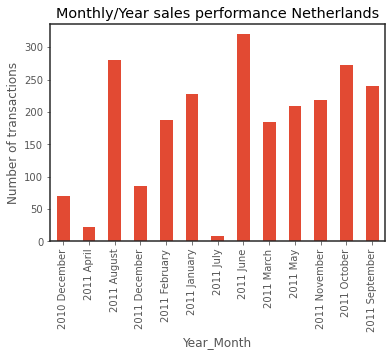

In [158]:
#Monthly/Year sales review

Items_NE.groupby('Year_Month')['description'].count().plot(kind='bar')
plt.ylabel('Number of transactions')
plt.title('Monthly/Year sales performance Netherlands')

In [75]:
#Monthly bestseller product - 12 DAISY PEGS IN WOOD BOX in April

Items_NE2=Items_NE.pivot_table(index='Month_name',columns='description', aggfunc={'description':'count'}).fillna(0)
Items_NE2['Max']=Items_NE2.idxmax(axis=1)
Items_NE2.head(5)

description                                \
description 10 COLOUR SPACEBOY PEN 12 PENCIL SMALL TUBE WOODLAND   
Month_name                                                         
April                          0.0                           0.0   
August                         1.0                           0.0   
December                       0.0                           0.0   
February                       0.0                           0.0   
January                        0.0                           0.0   

                                                 \
description 12 PENCILS SMALL TUBE RED RETROSPOT   
Month_name                                        
April                                       0.0   
August                                      0.0   
December                                    0.0   
February                                    0.0   
January                                     0.0   

                                                                              \
description 12 PENCILS TALL TUBE RED RETROSPOT 12 PENCILS TALL TUBE WOODLAND   
Month_name                                                                     
April                                      0.0                           0.0   
August                                     0.0                           0.0   
December                                   0.0                           0.0   
February                                   0.0                           0.0   
January                                    0.0                           0.0   

                                                                        \
description 16 PIECE CUTLERY SET PANTRY DESIGN 20 DOLLY PEGS RETROSPOT   
Month_name                                                               
April                                      0.0                     0.0   
August                                     0.0                     1.0   
December                                   0.0                     0.0   
February                                   0.0                     0.0   
January                                    0.0                     0.0   

                                                                             \
description 200 RED + WHITE BENDY STRAWS 3 HEARTS HANGING DECORATION RUSTIC   
Month_name                                                                    
April                                0.0                                0.0   
August                               0.0                                1.0   
December                             1.0                                0.0   
February                             0.0                                0.0   
January                              1.0                                0.0   

                                        ...                   \
description 3 HOOK HANGER MAGIC GARDEN  ... WRAP WEDDING DAY   
Month_name                              ...                    
April                              1.0  ...              0.0   
August                             1.0  ...              1.0   
December                           0.0  ...              0.0   
February                           0.0  ...              0.0   
January                            1.0  ...              0.0   

                                                                   \
description YELLOW METAL CHICKEN HEART ZINC  HEART T-LIGHT HOLDER   
Month_name                                                          
April                              0.0                        0.0   
August                             0.0                        0.0   
December                           1.0                        0.0   
February                           1.0                        0.0   
January                            0.0                        0.0   

                                                                 \
description ZINC  STAR T-LIGHT HOLDER ZINC FOLKART SLEIGH BELLS   
Mo

In [76]:
#Apriori Algorithm and Association analysanalysis 
#Sppliting the data for Netherlands market

basket_NE = (df_NE[df_NE['country'] =="Netherlands"]
          .groupby(['invoiceno', 'description'])['quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('invoiceno'))

basket_NE

description,10 COLOUR SPACEBOY PEN,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,16 PIECE CUTLERY SET PANTRY DESIGN,20 DOLLY PEGS RETROSPOT,200 RED + WHITE BENDY STRAWS,3 HEARTS HANGING DECORATION RUSTIC,3 HOOK HANGER MAGIC GARDEN,...,WRAP RED APPLES,WRAP WEDDING DAY,YELLOW METAL CHICKEN HEART,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
invoiceno,,,,,,,,,,,,,,,,,,,,,
536403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
539491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
539731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,192.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
541206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
541570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578143,0.0,384.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
579528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
#lists of items that are bought together.

lst=[]

for items in Items_NE['invoiceno'].unique():
    lst2=list(set(Items_NE[Items_NE['invoiceno']==items]['description']))
    if len(lst2)>0:
        lst.append(lst2)
        
print(lst[0:2])
print(len(lst))

[['HAND WARMER BIRD DESIGN'], ['JUMBO STORAGE BAG SUKI', 'PACK OF 20 SPACEBOY NAPKINS', 'RED RETROSPOT BIG BOWL', 'RETROSPOT PARTY BAG + STICKER SET', 'SET OF 3 CAKE TINS PANTRY DESIGN', '200 RED + WHITE BENDY STRAWS', 'CHARLOTTE BAG SUKI DESIGN', 'SET/10 IVORY POLKADOT PARTY CANDLES', 'FUNKY WASHING UP GLOVES ASSORTED', 'PACK OF 12 PINK POLKADOT TISSUES', 'PINK PARTY BAGS', 'JAM MAKING SET WITH JARS', 'WOODLAND PARTY BAG + STICKER SET', 'PENCIL CASE LIFE IS BEAUTIFUL', 'PACK OF 12 WOODLAND TISSUES']]
94


In [78]:
# Encoding the dataset
basket_encoded = basket_NE.applymap(hot_encode)
basket_NE = basket_encoded


# Building the model
NEfrq_items = apriori(basket_NE, min_support = 0.05, use_colnames = True)
 
# Collecting the inferred rules in a dataframe
NErules = association_rules(NEfrq_items, metric ="lift", min_threshold = 1)
NErules = NErules.sort_values(['confidence', 'lift'], ascending =[False, False])

#saving results in dataframe
NErule = pd.DataFrame(NErules)

NErule

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
650,(FOLDING BUTTERFLY MIRROR HOT PINK),(FOLDING BUTTERFLY MIRROR RED),0.053191,0.053191,0.053191,1.000000,18.800000,0.050362,inf
651,(FOLDING BUTTERFLY MIRROR RED),(FOLDING BUTTERFLY MIRROR HOT PINK),0.053191,0.053191,0.053191,1.000000,18.800000,0.050362,inf
1351,"(FOOD CONTAINER SET 3 LOVE HEART, CARD DOLLY G...",(10 COLOUR SPACEBOY PEN),0.053191,0.053191,0.053191,1.000000,18.800000,0.050362,inf
1354,(10 COLOUR SPACEBOY PEN),"(FOOD CONTAINER SET 3 LOVE HEART, CARD DOLLY G...",0.053191,0.053191,0.053191,1.000000,18.800000,0.050362,inf
1382,"(CARD DOLLY GIRL, STRAWBERRY LUNCH BOX WITH CU...",(10 COLOUR SPACEBOY PEN),0.053191,0.053191,0.053191,1.000000,18.800000,0.050362,inf
...,...,...,...,...,...,...,...,...,...
221,(SPACEBOY LUNCH BOX),(CARD GINGHAM ROSE),0.297872,0.095745,0.053191,0.178571,1.865079,0.024672,1.100833
2765,(SPACEBOY LUNCH BOX),"(ROUND SNACK BOXES SET OF4 WOODLAND, CARD DOLL...",0.297872,0.095745,0.053191,0.178571,1.865079,0.024672,1.100833
2789,(SPACEBOY LUNCH BOX),"(SPACEBOY BIRTHDAY CARD, CARD DOLLY GIRL)",0.297872,0.095745,0.053191,0.178571,1.865079,0.024672,1.100833
205,(SPACEBOY LUNCH BOX),(CARD DOLLY GIRL),0.297872,0.127660,0.053191,0.178571,1.398810,0.015165,1.061980


In [79]:
NEproductA = list(NErule.iloc[0,0])[0]
print('The top seller product in EIRE is', NEproductA)

NENA = int(basket_NE[NEproductA].sum())
print('which was sold', NENA , 'times')

NEproductB = list(NErule.iloc[0,1])[0]
print('sold together with', NEproductB)

NE = int(basket_NE[NEproductB].sum())
print(' which was sold', NE)

Elift_A_C = str(round(NErule.iloc[0,6],2))

The top seller product in EIRE is FOLDING BUTTERFLY MIRROR HOT PINK
which was sold 5 times
sold together with FOLDING BUTTERFLY MIRROR RED
 which was sold 5


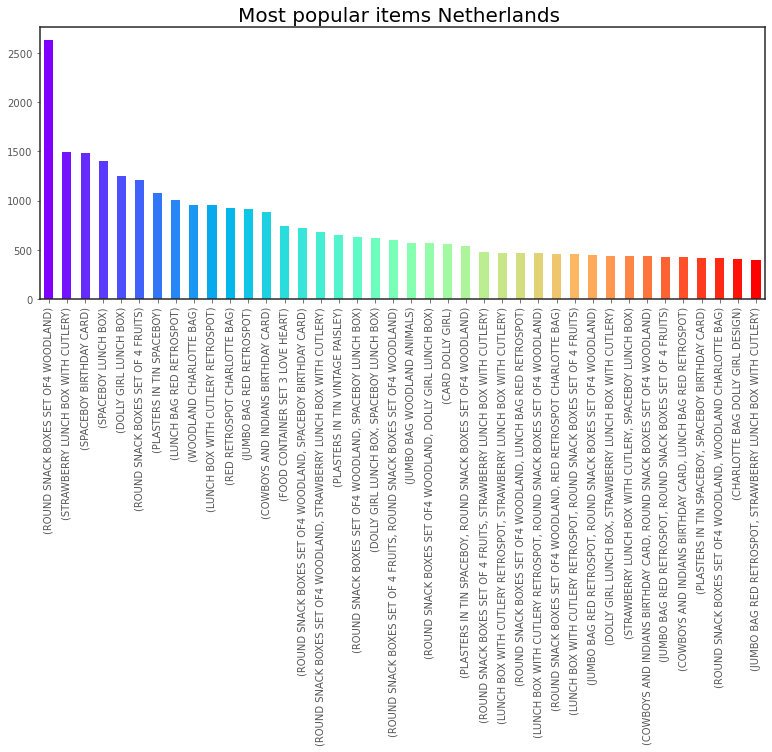

In [159]:
color = plt.cm.rainbow(np.linspace(0, 1, 40))
NErule['antecedents'].value_counts().head(40).plot.bar(color = color, figsize=(13,5))
plt.title('Most popular items Netherlands ', fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

In [220]:
NErule_sort = NErule.sort_values(['confidence', 'lift'], ascending =False)[:100]

NErule_sort.head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
650,(FOLDING BUTTERFLY MIRROR HOT PINK),(FOLDING BUTTERFLY MIRROR RED),0.053191,0.053191,0.053191,1.0,18.8,0.050362,inf
651,(FOLDING BUTTERFLY MIRROR RED),(FOLDING BUTTERFLY MIRROR HOT PINK),0.053191,0.053191,0.053191,1.0,18.8,0.050362,inf
1351,"(FOOD CONTAINER SET 3 LOVE HEART, CARD DOLLY G...",(10 COLOUR SPACEBOY PEN),0.053191,0.053191,0.053191,1.0,18.8,0.050362,inf
1354,(10 COLOUR SPACEBOY PEN),"(FOOD CONTAINER SET 3 LOVE HEART, CARD DOLLY G...",0.053191,0.053191,0.053191,1.0,18.8,0.050362,inf
1382,"(CARD DOLLY GIRL, STRAWBERRY LUNCH BOX WITH CU...",(10 COLOUR SPACEBOY PEN),0.053191,0.053191,0.053191,1.0,18.8,0.050362,inf


In [221]:
NErule_sort.antecedents = NErule_sort.antecedents.apply(lambda x: next(iter(x)))
NErule_sort.consequents = NErule_sort.consequents.apply(lambda x: next(iter(x)))

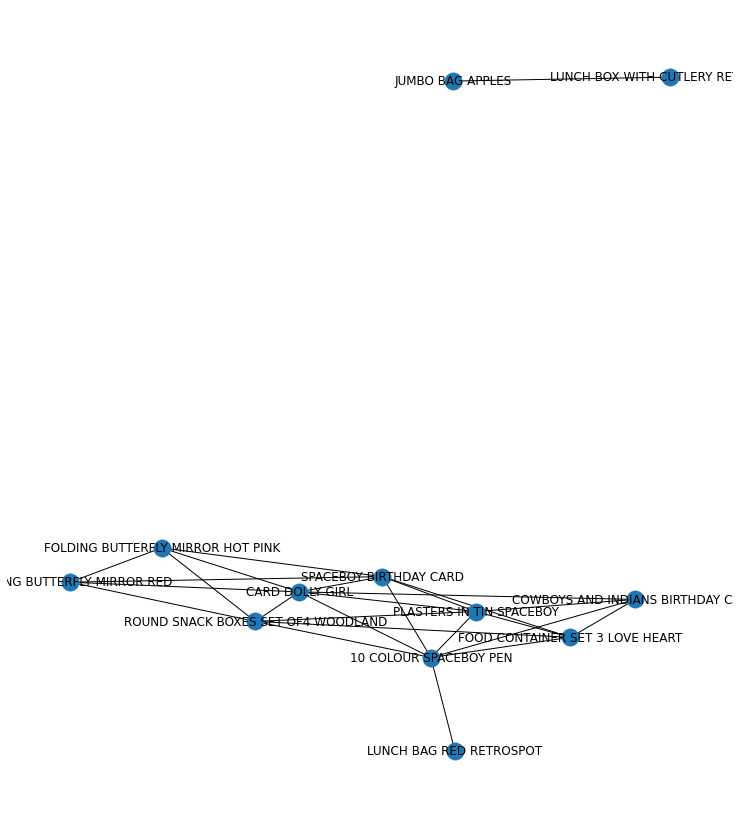

In [250]:
import networkx as nx

fig, ax=plt.subplots(figsize=(13,15))
GA=nx.from_pandas_edgelist(NErule_sort,source='antecedents',target='consequents')
nx.draw(GA,with_labels=True)
plt.show()

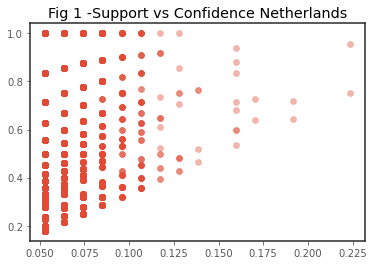

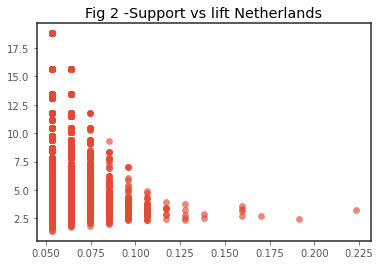

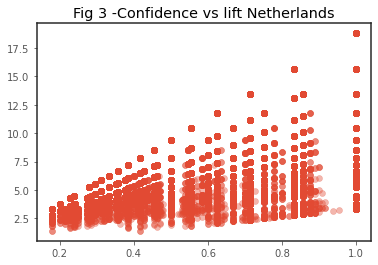

In [160]:
# Plotting results - Support vs Confidence vs lift

plt.scatter(NErule['support'], NErule['confidence'], alpha=0.4)
plt.title('Fig 1 -Support vs Confidence Netherlands')
plt.show()

plt.scatter(NErule['support'], NErule['lift'], alpha=0.4)
plt.title('Fig 2 -Support vs lift Netherlands')
plt.show()



plt.scatter(NErule['confidence'], NErule['lift'], alpha=0.4)
plt.title('Fig 3 -Confidence vs lift Netherlands')
plt.show()

In [85]:
################################## IRELEND ############################################

In [86]:
#Splitting Basket for Republic of Ireland (EIRE)

Items_EI = (df_EI[df_EI['country'] =="EIRE"])
          

Items_EI = pd.DataFrame(Items_EI)

Items_EI

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
1404,536540,22968,ROSE COTTAGE KEEPSAKE BOX,4,2010-12-01 14:05:00,9.95,14911.0,EIRE
1405,536540,85071A,BLUE CHARLIE+LOLA PERSONAL DOORSIGN,6,2010-12-01 14:05:00,2.95,14911.0,EIRE
1406,536540,85071C,"CHARLIE+LOLA""EXTREMELY BUSY"" SIGN",6,2010-12-01 14:05:00,2.55,14911.0,EIRE
1407,536540,22355,CHARLOTTE BAG SUKI DESIGN,50,2010-12-01 14:05:00,0.85,14911.0,EIRE
1408,536540,21579,LOLITA DESIGN COTTON TOTE BAG,6,2010-12-01 14:05:00,2.25,14911.0,EIRE
...,...,...,...,...,...,...,...,...
539151,581433,22192,BLUE DINER WALL CLOCK,2,2011-12-08 15:54:00,8.50,14911.0,EIRE
539152,581433,48187,DOORMAT NEW ENGLAND,2,2011-12-08 15:54:00,8.25,14911.0,EIRE
539153,581433,48184,DOORMAT ENGLISH ROSE,2,2011-12-08 15:54:00,8.25,14911.0,EIRE
539154,581433,20685,DOORMAT RED RETROSPOT,2,2011-12-08 15:54:00,8.25,14911.0,EIRE


In [87]:
# Quantity of unique items

Items_EI['description'].nunique()

2013

In [180]:
# Unique items quantity/description

Items_EI['description'].value_counts().sort_values(ascending=False).head(20)

REGENCY CAKESTAND 3 TIER              73
ROSES REGENCY TEACUP AND SAUCER       48
WHITE HANGING HEART T-LIGHT HOLDER    46
VINTAGE SNAP CARDS                    44
GREEN REGENCY TEACUP AND SAUCER       36
JAM MAKING SET PRINTED                36
SET OF 3 REGENCY CAKE TINS            35
JAM MAKING SET WITH JARS              35
PACK OF 72 RETROSPOT CAKE CASES       33
SET OF 3 CAKE TINS PANTRY DESIGN      32
BAKING SET 9 PIECE RETROSPOT          30
RECIPE BOX PANTRY YELLOW DESIGN       28
IVORY KITCHEN SCALES                  28
PINK REGENCY TEACUP AND SAUCER        28
REGENCY TEA PLATE ROSES               26
POPCORN HOLDER                        25
SPOTTY BUNTING                        25
REGENCY SUGAR BOWL GREEN              25
REGENCY MILK JUG PINK                 25
60 TEATIME FAIRY CAKE CASES           24
Name: description, dtype: int64

In [89]:
# Removed CARRIAGE (not a product)

Items_EI=Items_EI.drop(Items_EI.loc[Items_EI['description']=='CARRIAGE'].index)

Text(0.5, 1.0, 'Best sellers EIRE')

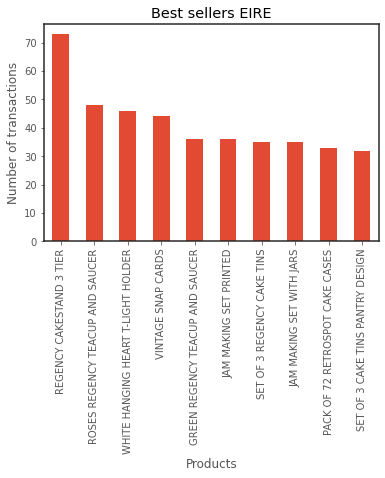

In [193]:
# Plotting best seller products

fig, ax=plt.subplots(figsize=(6,4))
Items_EI['description'].value_counts().sort_values(ascending=False).head(10).plot(kind='bar')
plt.ylabel('Number of transactions')
plt.xlabel('Products')
ax.get_yaxis().get_major_formatter().set_scientific(False)
plt.title('Best sellers EIRE')

In [91]:
#adding a Hour columns to show business best sale times

Items_EI['invoicedate'] = pd.to_datetime(Items_EI['invoicedate'])
Items_EI['Hour'] = Items_EI['invoicedate'].dt.hour
Items_EI['Minute'] = Items_EI['invoicedate'].dt.minute
Items_EI['Count'] = 1

Items_EI.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,Hour,Minute,Count
1404,536540,22968,ROSE COTTAGE KEEPSAKE BOX,4,2010-12-01 14:05:00,9.95,14911.0,EIRE,14,5,1
1405,536540,85071A,BLUE CHARLIE+LOLA PERSONAL DOORSIGN,6,2010-12-01 14:05:00,2.95,14911.0,EIRE,14,5,1
1406,536540,85071C,"CHARLIE+LOLA""EXTREMELY BUSY"" SIGN",6,2010-12-01 14:05:00,2.55,14911.0,EIRE,14,5,1
1407,536540,22355,CHARLOTTE BAG SUKI DESIGN,50,2010-12-01 14:05:00,0.85,14911.0,EIRE,14,5,1
1408,536540,21579,LOLITA DESIGN COTTON TOTE BAG,6,2010-12-01 14:05:00,2.25,14911.0,EIRE,14,5,1


In [92]:
hours = [pair for pair, df in Items_EI.groupby(['Hour'])]

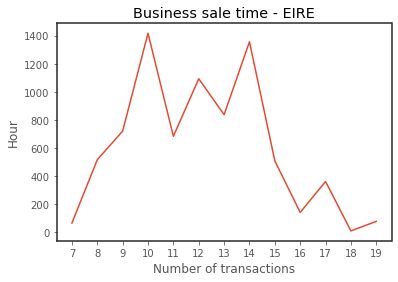

In [93]:
#Business best sale time

plt.figure(figsize=(6,4))
plt.plot(hours, Items_EI.groupby(['Hour']).count()['Count'])
plt.xticks(hours)
plt.xlabel("Number of transactions")
plt.ylabel("Hour")
plt.title('Business sale time - EIRE')
plt.grid()
plt.show()





In [94]:
#Extractin Months and Years for further analysis 

Items_EI['month'] = pd.DatetimeIndex(Items_EI['invoicedate']).month
Items_EI['Month_name']=Items_EI['invoicedate'].dt.month_name()
Items_EI['Year']=Items_EI['invoicedate'].dt.year
Items_EI['Year_Month']=Items_EI['Year'].apply(str)+' '+Items_EI['Month_name'].apply(str)

Items_EI

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,Hour,Minute,Count,month,Month_name,Year,Year_Month
1404,536540,22968,ROSE COTTAGE KEEPSAKE BOX,4,2010-12-01 14:05:00,9.95,14911.0,EIRE,14,5,1,12,December,2010,2010 December
1405,536540,85071A,BLUE CHARLIE+LOLA PERSONAL DOORSIGN,6,2010-12-01 14:05:00,2.95,14911.0,EIRE,14,5,1,12,December,2010,2010 December
1406,536540,85071C,"CHARLIE+LOLA""EXTREMELY BUSY"" SIGN",6,2010-12-01 14:05:00,2.55,14911.0,EIRE,14,5,1,12,December,2010,2010 December
1407,536540,22355,CHARLOTTE BAG SUKI DESIGN,50,2010-12-01 14:05:00,0.85,14911.0,EIRE,14,5,1,12,December,2010,2010 December
1408,536540,21579,LOLITA DESIGN COTTON TOTE BAG,6,2010-12-01 14:05:00,2.25,14911.0,EIRE,14,5,1,12,December,2010,2010 December
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539151,581433,22192,BLUE DINER WALL CLOCK,2,2011-12-08 15:54:00,8.50,14911.0,EIRE,15,54,1,12,December,2011,2011 December
539152,581433,48187,DOORMAT NEW ENGLAND,2,2011-12-08 15:54:00,8.25,14911.0,EIRE,15,54,1,12,December,2011,2011 December
539153,581433,48184,DOORMAT ENGLISH ROSE,2,2011-12-08 15:54:00,8.25,14911.0,EIRE,15,54,1,12,December,2011,2011 December
539154,581433,20685,DOORMAT RED RETROSPOT,2,2011-12-08 15:54:00,8.25,14911.0,EIRE,15,54,1,12,December,2011,2011 December


Text(0.5, 1.0, 'Monthly/Year sales performance EIRE')

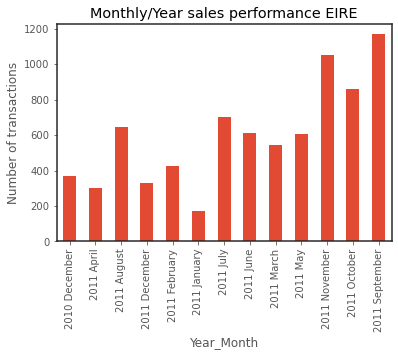

In [162]:
#Monthly/Year sales review

Items_EI.groupby('Year_Month')['description'].count().plot(kind='bar')
plt.ylabel('Number of transactions')
plt.title('Monthly/Year sales performance EIRE')


In [96]:
#Monthly bestseller product - 12 DAISY PEGS IN WOOD BOX in April

Items_EI2=Items_EI.pivot_table(index='Month_name',columns='description', aggfunc={'description':'count'}).fillna(0)
Items_EI2['Max']=Items_EI2.idxmax(axis=1)
Items_EI2.head(5)

description                             \
description 10 COLOUR SPACEBOY PEN 12 COLOURED PARTY BALLOONS   
Month_name                                                      
April                          0.0                        0.0   
August                         0.0                        0.0   
December                       1.0                        0.0   
February                       0.0                        0.0   
January                        0.0                        0.0   

                                                                 \
description 12 DAISY PEGS IN WOOD BOX 12 EGG HOUSE PAINTED WOOD   
Month_name                                                        
April                             3.0                       1.0   
August                            0.0                       0.0   
December                          0.0                       1.0   
February                          0.0                       0.0   
January                           0.0                       0.0   

                                                                              \
description 12 IVORY ROSE PEG PLACE SETTINGS 12 MESSAGE CARDS WITH ENVELOPES   
Month_name                                                                     
April                                    0.0                             0.0   
August                                   0.0                             1.0   
December                                 0.0                             0.0   
February                                 2.0                             0.0   
January                                  0.0                             0.0   

                                                                               \
description 12 PENCIL SMALL TUBE WOODLAND 12 PENCILS SMALL TUBE RED RETROSPOT   
Month_name                                                                      
April                                 0.0                                 0.0   
August                                0.0                                 0.0   
December                              1.0                                 1.0   
February                              0.0                                 0.0   
January                               0.0                                 0.0   

                                                                          ...  \
description 12 PENCILS TALL TUBE POSY 12 PENCILS TALL TUBE RED RETROSPOT  ...   
Month_name                                                                ...   
April                             0.0                                0.0  ...   
August                            1.0                                0.0  ...   
December                          0.0                                0.0  ...   
February                          0.0                                0.0  ...   
January                           0.0                                0.0  ...   

                                                                         \
description ZINC HEART FLOWER T-LIGHT HOLDER ZINC HERB GARDEN CONTAINER   
Month_name                                                                
April                                    0.0                        0.0   
August                                   0.0                        1.0   
December                                 0.0                        0.0   
February                                 0.0                        0.0   
January                                  0.0                        0.0   

                                                                          \
description ZINC METAL HEART DECORATION ZINC SWEETHEART WIRE LETTER RACK   
Month_name                                                                 
April                               0.0                              0.0   
August                              0.0                              1.0   
December                            0.0      

In [97]:
#Apriori Algorithm and Association analysanalysis 
#Sppliting the data for EIRE market

basket_EIRE = (df_EI[df_EI['country'] =="EIRE"]
          .groupby(['invoiceno', 'description'])['quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('invoiceno'))

basket_EIRE

description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,...,ZINC FOLKART SLEIGH BELLS,ZINC HEART FLOWER T-LIGHT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
invoiceno,,,,,,,,,,,,,,,,,,,,,
536540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
581006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
#lists of items that are bought together.

lst=[]

for items in Items_EI['invoiceno'].unique():
    lst2=list(set(Items_EI[Items_EI['invoiceno']==items]['description']))
    if len(lst2)>0:
        lst.append(lst2)
        
print(lst[0:2])
print(len(lst))

[['YELLOW SHARK HELICOPTER', 'FELTCRAFT BUTTERFLY HEARTS', 'BOX OF VINTAGE ALPHABET BLOCKS', 'CHARLIE+LOLA"EXTREMELY BUSY" SIGN', 'LETS GO SHOPPING COTTON TOTE BAG', 'BLUE CHARLIE+LOLA PERSONAL DOORSIGN', 'PAINT YOUR OWN CANVAS SET', 'CAMOUFLAGE LED TORCH', 'ROSE COTTAGE KEEPSAKE BOX', 'CHARLOTTE BAG SUKI DESIGN', 'WOODEN BOX OF DOMINOES', 'TRADITIONAL WOODEN SKIPPING ROPE', '3 STRIPEY MICE FELTCRAFT', 'RED SHARK HELICOPTER', 'TOOL BOX SOFT TOY', "DOCTOR'S BAG SOFT TOY", 'BLUE DRAGONFLY HELICOPTER', 'LOLITA  DESIGN  COTTON TOTE BAG', 'MINI PAINT SET VINTAGE'], ['RED  HARMONICA IN BOX']]
282


In [99]:
# Encoding the dataset
basket_encoded = basket_EIRE.applymap(hot_encode)
basket_EIRE = basket_encoded


# Building the model
EIREfrq_items = apriori(basket_EIRE, min_support = 0.05, use_colnames = True)
 
# Collecting the inferred rules in a dataframe
EIRErules = association_rules(EIREfrq_items, metric ="lift", min_threshold = 1)
EIRErules = EIRErules.sort_values(['confidence', 'lift'], ascending =[False, False])

#saving results in dataframe
EIRErule = pd.DataFrame(EIRErules)

EIRErule

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
194,"(REGENCY TEA PLATE PINK, REGENCY CAKESTAND 3 T...",(REGENCY TEA PLATE GREEN),0.056338,0.080986,0.056338,1.000000,12.347826,0.051775,inf
184,"(REGENCY TEAPOT ROSES, REGENCY CAKESTAND 3 TIER)",(REGENCY SUGAR BOWL GREEN),0.052817,0.088028,0.052817,1.000000,11.360000,0.048168,inf
118,"(REGENCY CAKESTAND 3 TIER, GREEN REGENCY TEACU...",(ROSES REGENCY TEACUP AND SAUCER),0.088028,0.169014,0.088028,1.000000,5.916667,0.073150,inf
129,"(REGENCY SUGAR BOWL GREEN, GREEN REGENCY TEACU...",(ROSES REGENCY TEACUP AND SAUCER),0.063380,0.169014,0.063380,1.000000,5.916667,0.052668,inf
142,"(REGENCY TEAPOT ROSES, GREEN REGENCY TEACUP AN...",(ROSES REGENCY TEACUP AND SAUCER),0.052817,0.169014,0.052817,1.000000,5.916667,0.043890,inf
...,...,...,...,...,...,...,...,...,...
113,(REGENCY CAKESTAND 3 TIER),"(REGENCY TEA PLATE GREEN, GREEN REGENCY TEACUP...",0.250000,0.056338,0.052817,0.211268,3.750000,0.038732,1.196429
186,(REGENCY CAKESTAND 3 TIER),"(REGENCY SUGAR BOWL GREEN, REGENCY TEAPOT ROSES)",0.250000,0.063380,0.052817,0.211268,3.333333,0.036972,1.187500
45,(REGENCY CAKESTAND 3 TIER),(REGENCY TEAPOT ROSES),0.250000,0.066901,0.052817,0.211268,3.157895,0.036092,1.183036
180,(REGENCY CAKESTAND 3 TIER),"(ROSES REGENCY TEACUP AND SAUCER, REGENCY MILK...",0.250000,0.066901,0.052817,0.211268,3.157895,0.036092,1.183036


In [100]:
EproductA = list(EIRErule.iloc[0,0])[0]
print('The top seller product in EIRE is', EproductA)

ENA = int(basket_EIRE[EproductA].sum())
print('which was sold', ENA , 'times')

EproductB = list(EIRErule.iloc[0,1])[0]
print('sold together with', EproductB)

ENB = int(basket_EIRE[EproductB].sum())
print(' which was sold', ENB)

Elift_A_C = str(round(EIRErule.iloc[0,6],2))

The top seller product in EIRE is REGENCY TEA PLATE PINK
which was sold 20 times
sold together with REGENCY TEA PLATE GREEN
 which was sold 23


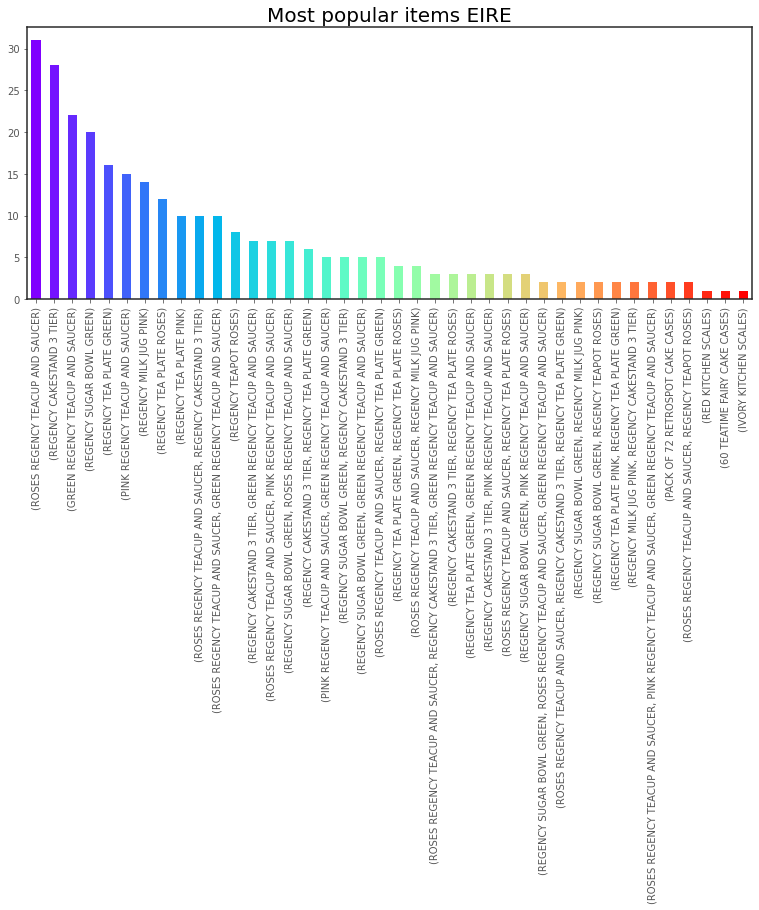

In [163]:
color = plt.cm.rainbow(np.linspace(0, 1, 40))
EIRErule['antecedents'].value_counts().head(40).plot.bar(color = color, figsize=(13,5))
plt.title('Most popular items EIRE', fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

In [227]:
EIRErule_sort = EIRErule.sort_values(['confidence', 'lift'], ascending =False)[:50]

EIRErule_sort

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
194,"(REGENCY TEA PLATE PINK, REGENCY CAKESTAND 3 T...",(REGENCY TEA PLATE GREEN),0.056338,0.080986,0.056338,1.000000,12.347826,0.051775,inf
184,"(REGENCY TEAPOT ROSES, REGENCY CAKESTAND 3 TIER)",(REGENCY SUGAR BOWL GREEN),0.052817,0.088028,0.052817,1.000000,11.360000,0.048168,inf
118,"(REGENCY CAKESTAND 3 TIER, GREEN REGENCY TEACU...",(ROSES REGENCY TEACUP AND SAUCER),0.088028,0.169014,0.088028,1.000000,5.916667,0.073150,inf
129,"(REGENCY SUGAR BOWL GREEN, GREEN REGENCY TEACU...",(ROSES REGENCY TEACUP AND SAUCER),0.063380,0.169014,0.063380,1.000000,5.916667,0.052668,inf
142,"(REGENCY TEAPOT ROSES, GREEN REGENCY TEACUP AN...",(ROSES REGENCY TEACUP AND SAUCER),0.052817,0.169014,0.052817,1.000000,5.916667,0.043890,inf
148,"(REGENCY CAKESTAND 3 TIER, PINK REGENCY TEACUP...",(ROSES REGENCY TEACUP AND SAUCER),0.070423,0.169014,0.070423,1.000000,5.916667,0.058520,inf
154,"(REGENCY MILK JUG PINK, PINK REGENCY TEACUP AN...",(ROSES REGENCY TEACUP AND SAUCER),0.056338,0.169014,0.056338,1.000000,5.916667,0.046816,inf
159,"(REGENCY SUGAR BOWL GREEN, PINK REGENCY TEACUP...",(ROSES REGENCY TEACUP AND SAUCER),0.059859,0.169014,0.059859,1.000000,5.916667,0.049742,inf
166,"(REGENCY TEA PLATE PINK, PINK REGENCY TEACUP A...",(ROSES REGENCY TEACUP AND SAUCER),0.052817,0.169014,0.052817,1.000000,5.916667,0.043890,inf
245,"(REGENCY CAKESTAND 3 TIER, PINK REGENCY TEACUP...",(ROSES REGENCY TEACUP AND SAUCER),0.066901,0.169014,0.066901,1.000000,5.916667,0.055594,inf


In [228]:
EIRErule_sort.antecedents = EIRErule_sort.antecedents.apply(lambda x: next(iter(x)))
EIRErule_sort.consequents = EIRErule_sort.consequents.apply(lambda x: next(iter(x)))

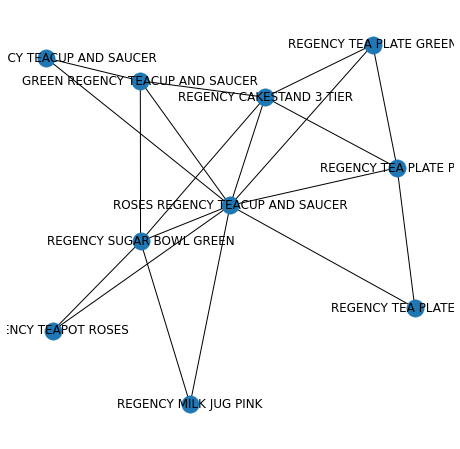

In [234]:
import networkx as nx

fig, ax=plt.subplots(figsize=(8,8))
GA=nx.from_pandas_edgelist(EIRErule_sort,source='antecedents',target='consequents')
nx.draw(GA,with_labels=True)
plt.show()


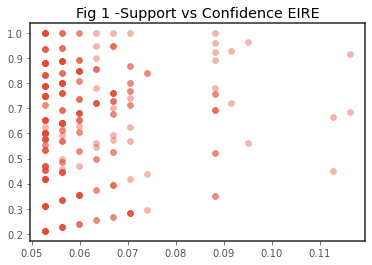

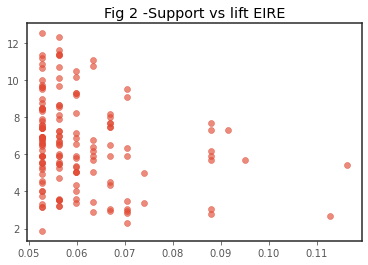

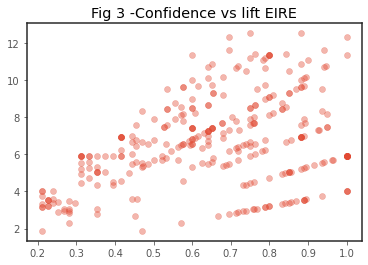

In [164]:
# Plotting results - Support vs Confidence vs lift

plt.scatter(EIRErule['support'], EIRErule['confidence'], alpha=0.4)
plt.title('Fig 1 -Support vs Confidence EIRE')
plt.show()

plt.scatter(EIRErule['support'], EIRErule['lift'], alpha=0.4)
plt.title('Fig 2 -Support vs lift EIRE')
plt.show()



plt.scatter(EIRErule['confidence'], EIRErule['lift'], alpha=0.4)
plt.title('Fig 3 -Confidence vs lift EIRE')
plt.show()

In [ ]:
######################################### FINAL 